In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

Problem 1. Canny Edge Detection

Smoothing with Gaussian kernel

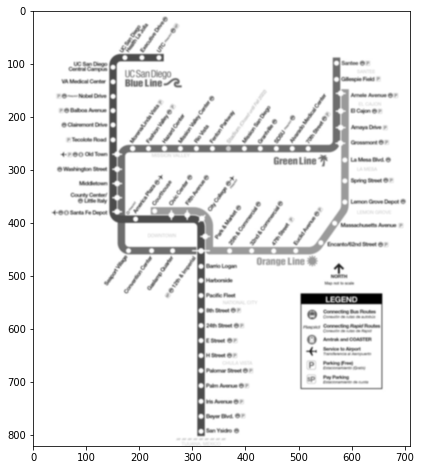

In [2]:
img = cv2.imread('test.jpg')
#img = cv2.imread('geisel.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = np.array(img, dtype = np.float32)
kern = np.array([[2,4,5,4,2],[4,9,12,9,4],[5,12,15,12,5],[4,9,12,9,4],[2,4,5,4,2]], dtype = np.float32) / 159

img_smoothed = cv2.filter2D(img, -1, kern)

plt.figure(figsize=(8,8))
plt.imshow(img_smoothed, cmap = 'gray')

Finding gradients with Sobel operator

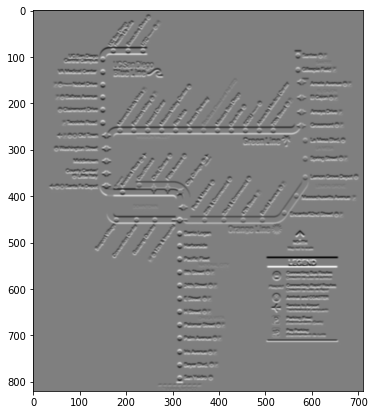

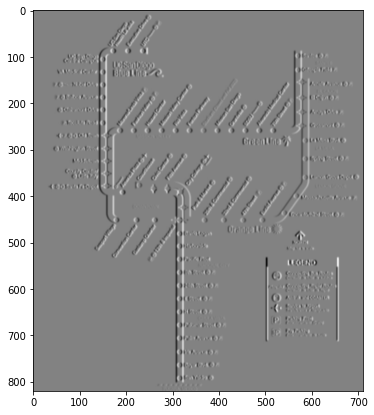

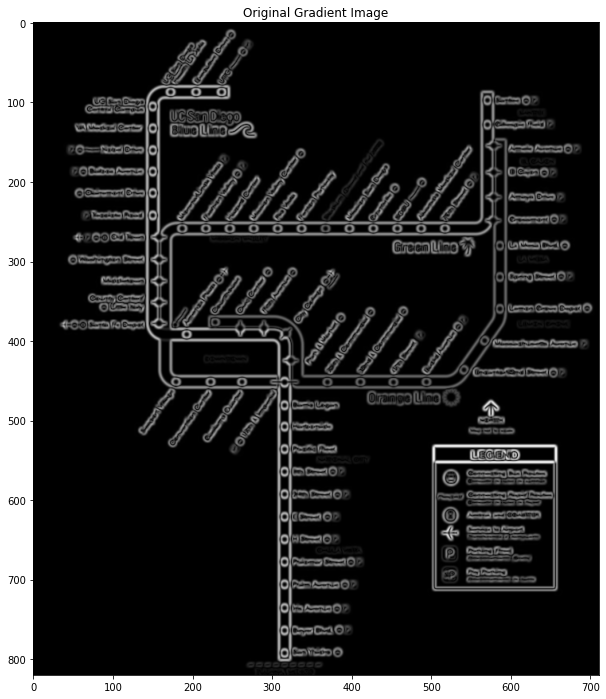

In [3]:
sobel_x = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype = np.float32)
sobel_y = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype = np.float32)

img_pad = np.pad(img_smoothed, (1, 1), mode = 'reflect')
img_Gx = cv2.filter2D(img_smoothed, -1, sobel_x)
img_Gy = cv2.filter2D(img_smoothed, -1, sobel_y)

img_G = np.sqrt(img_Gx ** 2 + img_Gy ** 2)
img_G *= 255 / np.max(img_G)

plt.figure(figsize=(7,7))
plt.imshow(img_Gx, cmap = 'gray')
plt.figure(figsize=(7,7))
plt.imshow(img_Gy, cmap = 'gray')
plt.figure(figsize=(12,12))
plt.title('Original Gradient Image')
plt.imshow(img_G, cmap = 'gray')

Non-maximum Suppression (NMS)

In [4]:
img_G_theta = np.zeros(img.shape)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if (img_Gx[i][j] == 0):
            img_G_theta[i][j] = np.pi / 2
        else:
            img_G_theta[i][j] = np.arctan(img_Gy[i][j] / img_Gx[i][j])

img_G_theta *= 180. / np.pi
img_G_theta[img_G_theta < 0] += 180

In [5]:
row, col = img_G_theta.shape
pi = np.pi

for r in range(1, row-1):
    for c in range(1, col-1):
        neighbor_1 = 0
        neighbor_2 = 0
        if (0 <= img_G_theta[r,c] < 22.5 or 157.5 <= img_G_theta[r,c] < 180):
                neighbor_1 = img_G[r,c-1]
                neighbor_2 = img_G[r,c+1]
        elif (22.5 <= img_G_theta[r,c] < 67.5):
                neighbor_1 = img_G[r+1,c+1]
                neighbor_2 = img_G[r-1,c-1]
        elif (67.5 <= img_G_theta[r,c] < 112.5):
                neighbor_1 = img_G[r-1,c]
                neighbor_2 = img_G[r+1,c]
        elif (112.5 <= img_G_theta[r,c] < 157.5):
                neighbor_1 = img_G[r-1,c+1]
                neighbor_2 = img_G[r+1,c-1]
            
        # Suppress condition
        if(img_G[r,c] < neighbor_1 or img_G[r,c] < neighbor_2):
            img_G[r,c] = 0
            

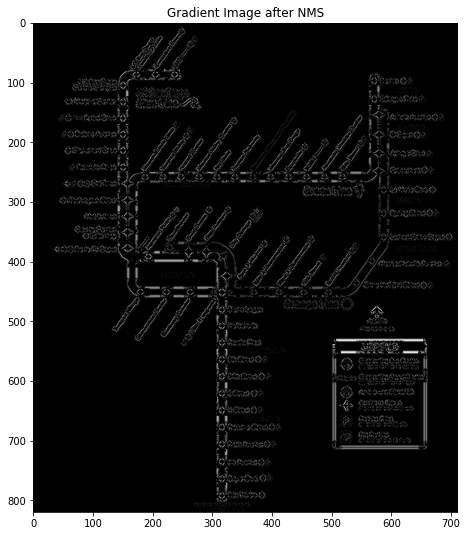

In [6]:
plt.figure(figsize=(9,9))
plt.title('Gradient Image after NMS')
plt.imshow(img_G,cmap = 'gray')

te = 40

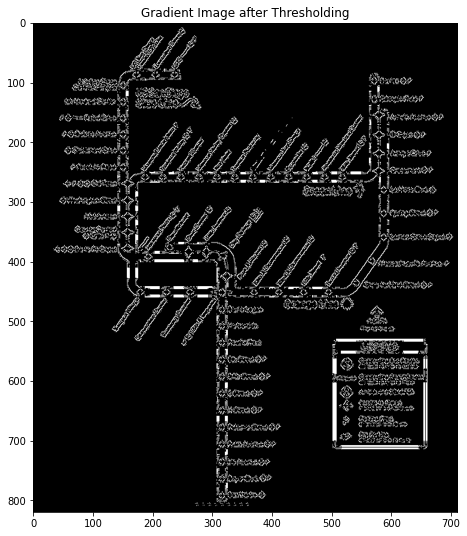

In [7]:
te = 40
a = np.array(img_G)
a[a >= te] = 255
a[a < te] = 0

plt.figure(figsize=(9,9))
plt.title('Gradient Image after Thresholding')
plt.imshow(np.array(a, dtype = np.uint8), cmap = 'gray')

Problem 2. Butterworth Notch Reject Filtering in Frequency Domain

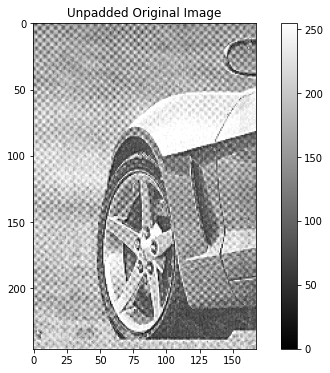

In [8]:
img = cv2.imread('Car.tif', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(9,6))
plt.title('Unpadded Original Image')
plt.imshow(img, cmap = 'gray')
plt.colorbar()

Zero padding to 512*512

In [9]:
row, col = img.shape
pad_row, pad_col = int((512 - row) / 2), int((512 - col) / 2)
img_pad = np.pad(img, ((pad_row, pad_row), (pad_col, pad_col)), mode = 'constant')

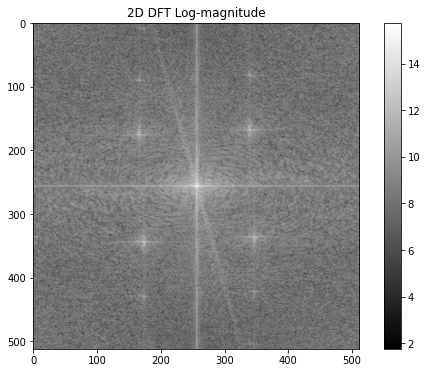

In [10]:
img_pad_fft = np.fft.fft2(img_pad)
img_pad_fft_shift = np.fft.fftshift(img_pad_fft)
magnitude_spectrum = np.log(np.abs(img_pad_fft_shift))

plt.figure(figsize=(9,6))
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('2D DFT Log-magnitude')
plt.colorbar()
plt.show()

In [11]:
x_axis = np.linspace(-256, 255, 512)
y_axis = np.linspace(-256, 255, 512)
[u,v] = np.meshgrid(x_axis, y_axis)

In [12]:
def dk(u, v, uk, vk):
    return np.sqrt((u - uk) ** 2 + (v - vk) ** 2)

def d_k(u, v, uk, vk):
    return np.sqrt((u + uk) ** 2 + (v + vk) ** 2)

def single_HP(d0, n, uk, vk):
    return 1 / (1 + (d0 / dk(u,v,uk,vk)) ** (2*n)) * 1 / (1 + (d0 / d_k(u,v,uk,vk)) ** (2*n))

In [13]:
def HNr(pulse, n, d0):
    NR_filter = 1

    for i in range(len(pulse)):
        uk, vk = pulse_uv[i] - 256
        NR_filter *= single_HP(d0, n, uk, vk)

    return NR_filter

pulse_uv = np.array([[346,336],[346,421],[339,83], [339,168]])
Nr_car = HNr(pulse_uv, 4, 20)
print('n =', 4)
print('D0 =', 20)
print('[uk, vk] =\n', pulse_uv)

n = 4
D0 = 20
[uk, vk] =
 [[346 336]
 [346 421]
 [339  83]
 [339 168]]


/tmp/ipykernel_8968/4117351830.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (1 + (d0 / dk(u,v,uk,vk)) ** (2*n)) * 1 / (1 + (d0 / d_k(u,v,uk,vk)) ** (2*n))


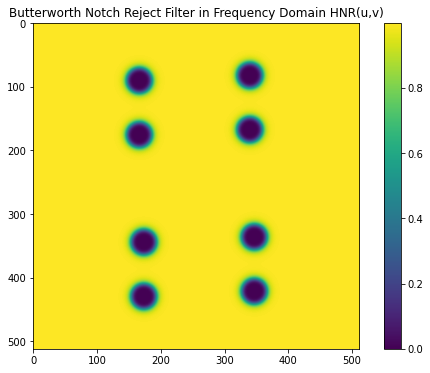

In [14]:
plt.figure(figsize=(9,6))
plt.imshow(Nr_car)
plt.title('Butterworth Notch Reject Filter in Frequency Domain HNR(u,v)')
plt.colorbar()
plt.show()

In [15]:
fft_filtered = np.fft.fftshift(img_pad_fft) * Nr_car
fft_filtered_inverse_shift = np.fft.ifftshift(fft_filtered)
img_NR_filter = abs(np.fft.ifft2(fft_filtered_inverse_shift))

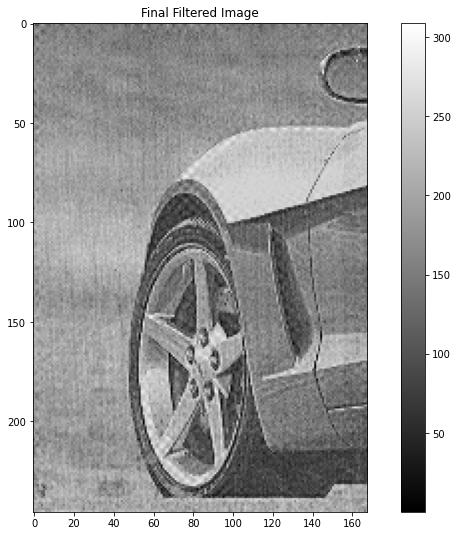

In [16]:
row, col = img.shape
plt.figure(figsize=(12,9))
plt.title('Final Filtered Image')
plt.imshow(img_NR_filter[pad_row:pad_row + row, pad_col:pad_col + col], cmap = 'gray')
plt.colorbar()

Street.png

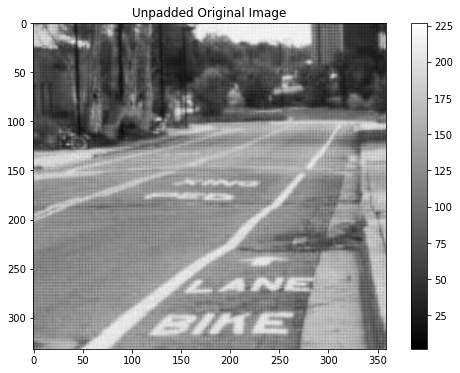

In [17]:
img = cv2.imread('Street.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(9,6))
plt.title('Unpadded Original Image')
plt.imshow(img, cmap = 'gray')
plt.colorbar()

In [18]:
row, col = img.shape
pad_row, pad_col = int((512 - row) / 2), int((512 - col) // 2)
img_pad = np.pad(img, ((pad_row, pad_row), (pad_col, pad_col+1)), mode = 'constant')

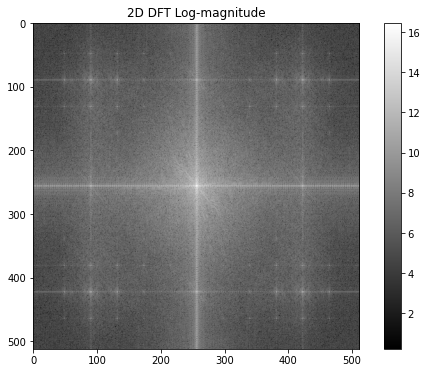

In [19]:
img_pad_fft = np.fft.fft2(img_pad)
img_pad_fft_shift = np.fft.fftshift(img_pad_fft)
magnitude_spectrum = np.log(np.abs(img_pad_fft_shift))

plt.figure(figsize=(9,6))
plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('2D DFT Log-magnitude')
plt.colorbar()
plt.show()

In [20]:
pulse_uv = np.array([[256,422],[422,256]])
Nr_street = HNr(pulse_uv, 4, 20)
print('n =', 4)
print('D0 =', 20)
print('[uk, vk] =\n', pulse_uv)

n = 4
D0 = 20
[uk, vk] =
 [[256 422]
 [422 256]]


/tmp/ipykernel_8968/4117351830.py:8: RuntimeWarning: divide by zero encountered in true_divide
  return 1 / (1 + (d0 / dk(u,v,uk,vk)) ** (2*n)) * 1 / (1 + (d0 / d_k(u,v,uk,vk)) ** (2*n))


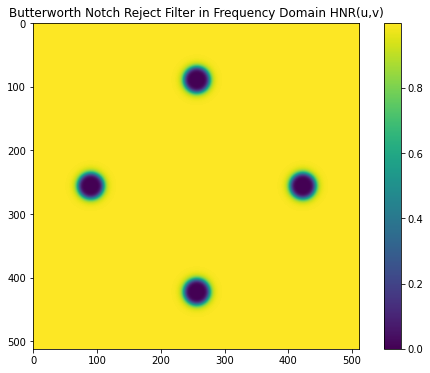

In [21]:
plt.figure(figsize=(9,6))
plt.imshow(Nr_street)
plt.title('Butterworth Notch Reject Filter in Frequency Domain HNR(u,v)')
plt.colorbar()
plt.show()

In [22]:
fft_filtered = np.fft.fftshift(img_pad_fft) * Nr_street
fft_filtered_inverse_shift = np.fft.ifftshift(fft_filtered)
img_NR_filter = abs(np.fft.ifft2(fft_filtered_inverse_shift))

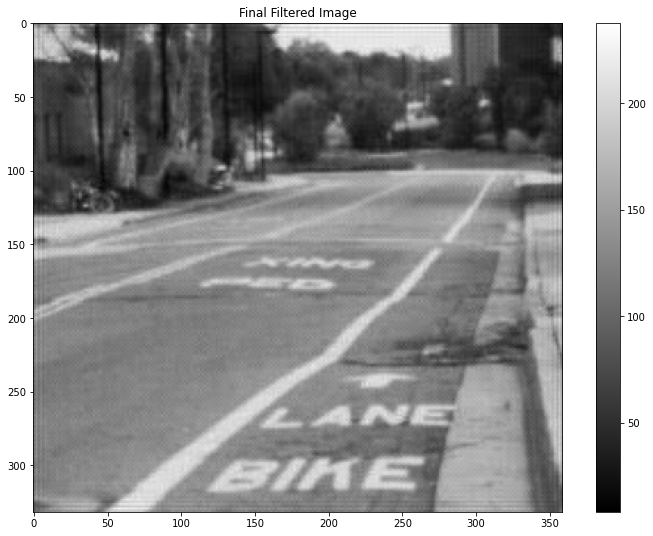

In [23]:
row, col = img.shape
plt.figure(figsize=(12,9))
plt.title('Final Filtered Image')
plt.imshow(img_NR_filter[pad_row:pad_row + row, pad_col:pad_col + col], cmap = 'gray')
plt.colorbar()

Problem 3. PyTorch tutorial and questions

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms

In [25]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


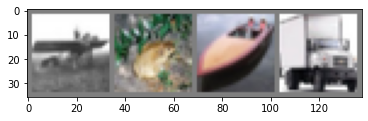

plane  frog  ship truck


In [26]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [27]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.875
[1,  6000] loss: 1.707
[1,  8000] loss: 1.632
[1, 10000] loss: 1.526
[1, 12000] loss: 1.489
[2,  2000] loss: 1.425
[2,  4000] loss: 1.421
[2,  6000] loss: 1.360
[2,  8000] loss: 1.330
[2, 10000] loss: 1.335
[2, 12000] loss: 1.314
Finished Training


In [30]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [31]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


In [32]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 58.4 %
Accuracy for class car   is: 79.8 %
Accuracy for class bird  is: 52.7 %
Accuracy for class cat   is: 39.9 %
Accuracy for class deer  is: 25.6 %
Accuracy for class dog   is: 33.3 %
Accuracy for class frog  is: 71.2 %
Accuracy for class horse is: 51.3 %
Accuracy for class ship  is: 48.5 %
Accuracy for class truck is: 62.2 %


ii. In this example, 50000 images are used. Each batch has 4 images, so the number od batches is 12500

In [33]:
print(trainset.__len__())
print(trainset.__len__() // batch_size)

50000
12500


iii. Normalization was done by this declaration: "transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])"

iv. Plotting training loss

Text(0.5, 1.0, 'Sample')

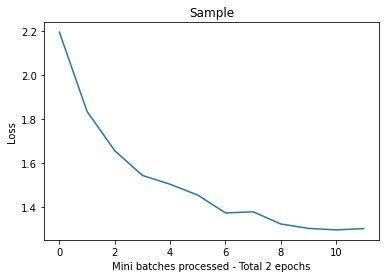

In [34]:
loss_l = [2.194, 1.835, 1.657, 1.545, 1.505, 1.456, 1.375, 1.380, 1.325, 1.305, 1.298, 1.304]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(loss_l)
ax.set_xlabel('Mini batches processed - Total 2 epochs')
ax.set_ylabel('Loss')
ax.set_title('Sample')

v. Failure (first and second image) and successful (third and fourth) cases are shown below.

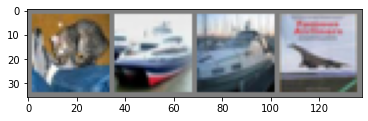

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car  ship


In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

vi. Can you visualize the output of the 1st layer of CNN using one image from the training set?

In [36]:
all_net_params = list(net.parameters())

# New class of NN for visualization
class Net_vis(nn.Module):
    def __init__(self, params_layer_1):
        super(Net_vis, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1.weight = params_layer_1 
    def forward(self, x):
        x = self.conv1(x)
        return x

net_2 = Net_vis(all_net_params[0])
first_layer_output = net_2(images)

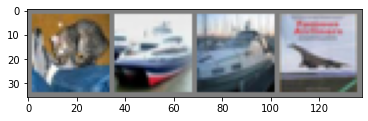

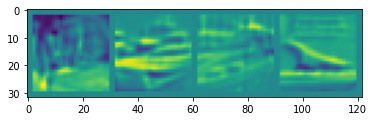

In [38]:
def imshow_detach(img):
    npimg = img.detach().numpy()
    npimg_tp = np.transpose(npimg, (1, 2, 0))
    npimg_tp_avg = np.mean(npimg_tp, axis = 2)
    plt.imshow(npimg_tp_avg)
    plt.show()

imshow(torchvision.utils.make_grid(images))
imshow_detach(torchvision.utils.make_grid(first_layer_output))